In [48]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt
import hvplot.xarray  # noqa
#
import pynsitu as pyn
from pynsitu.maps import crs

import dask.dataframe as dd
from lib import raw_dir, root_dir, smoothed_dir, KEYS

import datetime
from scipy.stats import norm

In [ ]:
bins = 

________
# LOAD

In [7]:
L1_files = glob(os.path.join(raw_dir, 'L1_*.nc'))
L1_files = [f for f in L1_files if 'all' not in f]#not include all because change in dt (not ok with integration)
L2_files = glob(os.path.join(smoothed_dir, 'L2_*.nc'))

In [8]:
list_type = np.unique(['_'.join(f.split('_')[2:5]) for f in L2_files])
list_type

array(['carthe_cnr_5min', 'carthe_lops_5min', 'carthe_uwa_5min',
       'code_ogs_10min', 'melodi_eodyn_10min', 'spotter_lops_30min',
       'svp_bcg_10min', 'svp_ogs_10min', 'svp_ogs_1h',
       'svp_scripps_10min', 'svp_scripps_1h', 'svp_shom_10min'],
      dtype='<U18')

In [11]:
list_type_2 = ['carthe_cnr_5min', 'carthe_lops_5min', 'carthe_uwa_5min',
       'code_ogs_10min', 'melodi_eodyn_10min', 'spotter_lops_30min',
       'svp_bcg_10min', 'svp_ogs_10min', 'svp_ogs_1h',
       'svp_scripps_10min', 'svp_scripps_1h']

In [9]:
#ds = xr.open_dataset(L1_files[0])
def open_L1_dataset(files_list, drifter_type):
    l = drifter_type.split('_')
    find=False
    for f in files_list :
        if '_'.join(l[0:1]) in f and l[-1]+'.nc' in f:
            find = True
            break
    assert find
    ds = xr.open_dataset(f)
    ds = ds.rename({'velocity_east':'u', 'velocity_north':'v', 'velocity':'U', 
                   'acceleration_east':'ax', 'acceleration_north':'ay', 'acceleration':'Axy',})
    sampling = f.split('_')[-1].replace('.nc', '')
    ds.attrs['raw_sampling']= sampling
    return ds

ds1 = open_L1_dataset(L1_files, 'carthe_lops_5min')
def open_L2_dataset(files_list, drifter_type, method, sampling):
    find=False
    for f in files_list :
        if drifter_type in f and sampling+'_v0' in f and method in f:
            find = True
            break
    assert find
    ds2 = xr.open_dataset(f)
    if 'uv' in ds2 :
        ds2=ds2.drop_vars('uv')
    return ds2  
ds2 = open_L2_dataset(L2_files, 'code_ogs_10min', 'variational', '30min')

In [ ]:
ds2

________
# MS

In [12]:
list_type_2 = ['carthe_cnr_5min', 'carthe_lops_5min', 'carthe_uwa_5min',
       'code_ogs_10min', 'melodi_eodyn_10min', 'spotter_lops_30min',
       'svp_bcg_10min', 'svp_ogs_10min', 'svp_ogs_1h',
       'svp_scripps_10min', 'svp_scripps_1h']

In [13]:
def rms_dataset_L2():
    L2_files = glob(os.path.join(smoothed_dir, 'L2_*.nc'))
    var_ms = ['x','y','u','v','ax','ay']
    def ms(ds):
        ds_=ds[var_ms]
        return ds_.var('time').mean('id')#np.sqrt((ds_**2).mean('time')).mean('id')
    list_method = ['variational','lowess']
    l_method = []
    for method in list_method:
        list_sampling = ['10min', '30min', '1h']
        l_sampling=[]
        for sampling in list_sampling:
            l_drifter_type =[]
            for drifter_type in list_type_2:
                try : ds = open_L2_dataset(L2_files, drifter_type, method, sampling)
                except : continue
                ds=ds.where(ds.gap_mask==0)
                l_drifter_type.append(ms(ds))
            l_sampling.append(xr.concat(l_drifter_type, dim = pd.Index(list_type_2, name='drifter_type')))
        l_method.append(xr.concat(l_sampling, dim = pd.Index(list_sampling, name='sampling')))
    return xr.concat(l_method, dim = pd.Index(list_method, name='smoothing_method'))

def rms_dataset_L1():
    L1_files = glob(os.path.join(raw_dir, 'L1_*.nc'))
    var_ms = ['x','y','u','v','ax','ay']
    def ms(ds):
        ds_=ds[var_ms]
        return ds_.var('time').mean('id')#np.sqrt((ds_**2).mean('time')).mean('id')
    l_drifter_type =[]
    for drifter_type in list_type_2:
        try : ds = open_L1_dataset(L1_files, drifter_type)
        except : continue
        l_drifter_type.append(ms(ds))
    return xr.concat(l_drifter_type, dim = pd.Index(list_type_2, name='drifter_type'))

dsms2 = rms_dataset_L2()     
dsms1 = rms_dataset_L1()

In [14]:
dsms1

<xarray.Dataset>
Dimensions:       (drifter_type: 11)
Coordinates:
  * drifter_type  (drifter_type) object 'carthe_cnr_5min' ... 'svp_scripps_1h'
Data variables:
    x             (drifter_type) float64 5.067e+09 5.067e+09 ... 1.229e+10
    y             (drifter_type) float64 5.899e+09 5.899e+09 ... 8.091e+09
    u             (drifter_type) float64 0.03275 0.03275 ... 0.02549 0.02013
    v             (drifter_type) float64 0.04353 0.04353 ... 0.02487 0.02421
    ax            (drifter_type) float64 1.799e-08 1.799e-08 ... 7.933e-11
    ay            (drifter_type) float64 5.899e-08 5.899e-08 ... 1.219e-10

<AxesSubplot: xlabel='drifter_type'>

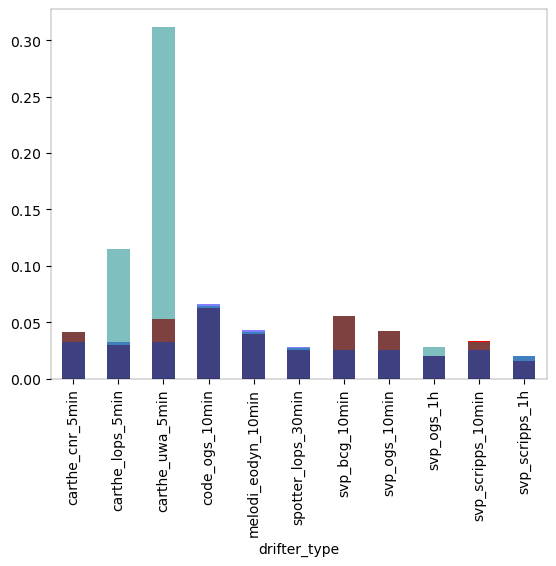

In [17]:
dsms2.u.sel(sampling='30min', smoothing_method='lowess').to_series().plot.bar(color='red')
dsms1.u.to_series().plot.bar(color='blue', alpha=0.5)
dsms2.u.sel(sampling='30min', smoothing_method='variational').to_series().plot.bar(color='teal', alpha=0.5)

________
# Distribution
## For all drifters types,raw, lowess, variational sampling =30min

In [35]:
def plot_histogram(darray, ax, bins=np.linspace(-1, 1, 30), **kwargs):
    h, b = np.histogram(darray, bins=bins, density=True)
    ax.plot(bins[:-1] + np.diff(bins) / 2, h, **kwargs)

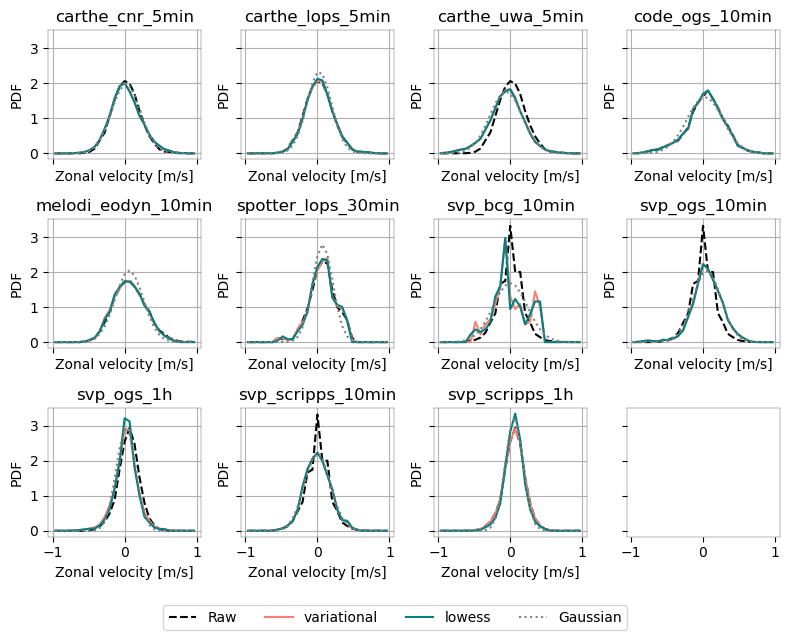

In [73]:
def plot_distribution(var, varlabel, bins=np.linspace(-1, 1, 30), ylim=None):
    fig, axs = plt.subplots(3,4,sharex=True,sharey=True, figsize=(8, 6))
    axs = axs.flatten()
    L2_files = glob(os.path.join(smoothed_dir, 'L2_*.nc'))
    list_method = ['variational','lowess']
    i=0
    lw=1.5
    for drifter_type in list_type_2:
        ax=axs[i]
        ax.grid()
        cm ={'lowess':'teal', 'variational':'salmon'}
        
        #RAW
        L1_files = glob(os.path.join(raw_dir, 'L1_*.nc'))
        ds1 = open_L1_dataset(L1_files, drifter_type)[var]
        if i==0: plot_histogram(ds1, ax=ax, bins=bins, color = 'k', ls='--', label='Raw', lw=lw)
        else : plot_histogram(ds1, ax=ax, bins=bins, color = 'k', ls='--', lw=lw)
        
        # SMOOTHED
        for method in list_method:
            sampling='30min'
            try : 
                ds2 = open_L2_dataset(L2_files, drifter_type, method, sampling)
            except : continue
            ds2 = ds2.where(ds2.gap_mask==0)[var]# exclude gaps
            if i ==0: plot_histogram(ds2, ax=ax, color = cm[method],bins=bins, label = method, lw=lw)
            else : plot_histogram(ds2, ax=ax,bins=bins, color = cm[method], lw=lw)
        
        #GAUSSIAN for comparison
        binspdf = bins[:-1] + np.diff(bins) / 2
        mean = ds2.mean()
        std = ds2.std('time').mean('id')
        pdf = norm.pdf(binspdf, mean, std)
        if i==0 : ax.plot(binspdf, pdf, c="grey", ls=':', label="Gaussian", lw=lw)
        else : ax.plot(binspdf, pdf, c="grey", ls=':', lw=lw)
            
        ax.set_xlabel(varlabel)
        ax.set_ylabel('PDF')
        ax.set_title(drifter_type)
        if ylim : ax.set_ylim(ylim)
        i+=1
        
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.005), ncol=4)
    fig.tight_layout()
    return fig
        
fig = plot_distribution('u', 'Zonal velocity [m/s]')           

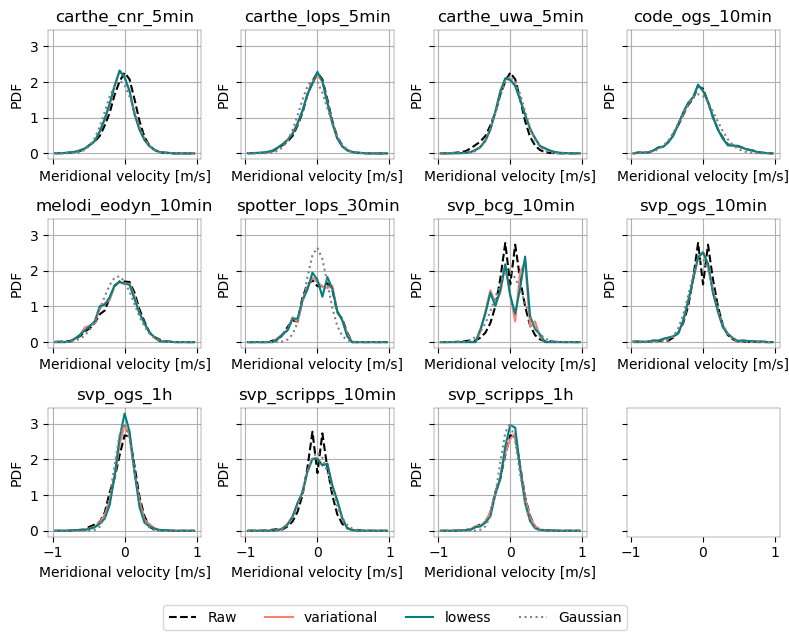

In [74]:
fig = plot_distribution('v', 'Meridional velocity [m/s]') 

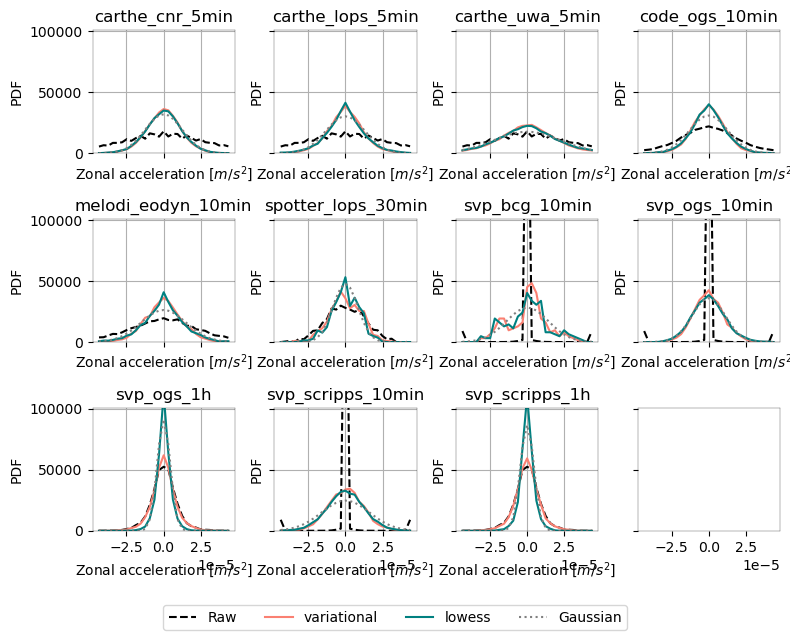

In [75]:
fig = plot_distribution('ax', r'Zonal acceleration $[m/s^2]$', bins=np.linspace(-4.5e-5,4.5e-5, 30), ylim=(0,101000)) 

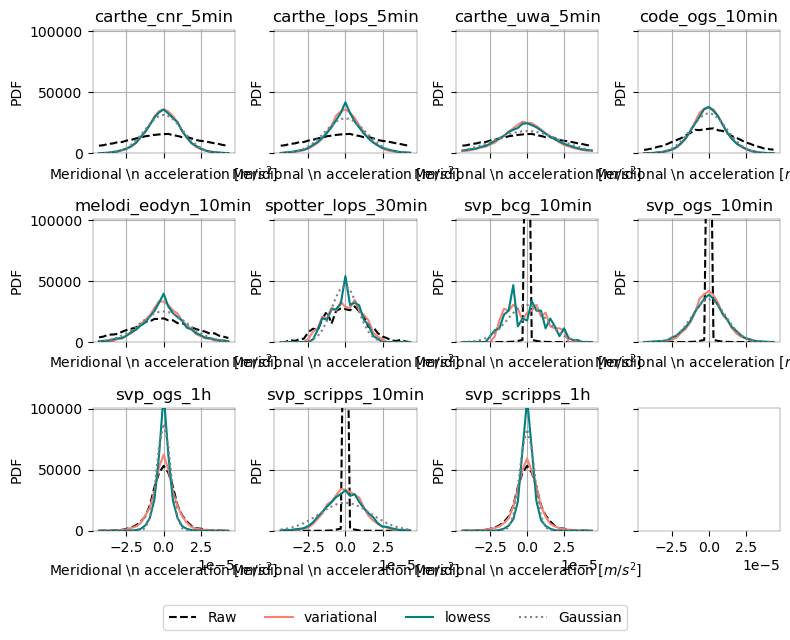

In [76]:
fig = plot_distribution('ay', r'Meridional \n acceleration $[m/s^2]$', bins=np.linspace(-4.5e-5,4.5e-5, 30), ylim=(0,101000))

## One type, different sampling